In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [3]:
# Load dataset
data = pd.read_csv('dataset/nation.csv')


In [4]:
# Display dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2948 entries, 0 to 2947
Data columns (total 37 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   area_type                                              2948 non-null   object 
 1   area_name                                              2948 non-null   object 
 2   area_code                                              2948 non-null   object 
 3   date                                                   2948 non-null   object 
 4   new_cases_by_publish_date                              2934 non-null   float64
 5   cum_cases_by_publish_date                              2934 non-null   float64
 6   cum_cases_by_publish_date_rate                         2896 non-null   float64
 7   new_cases_by_specimen_date                             2944 non-null   float64
 8   cum_cases_by_specimen_date                      

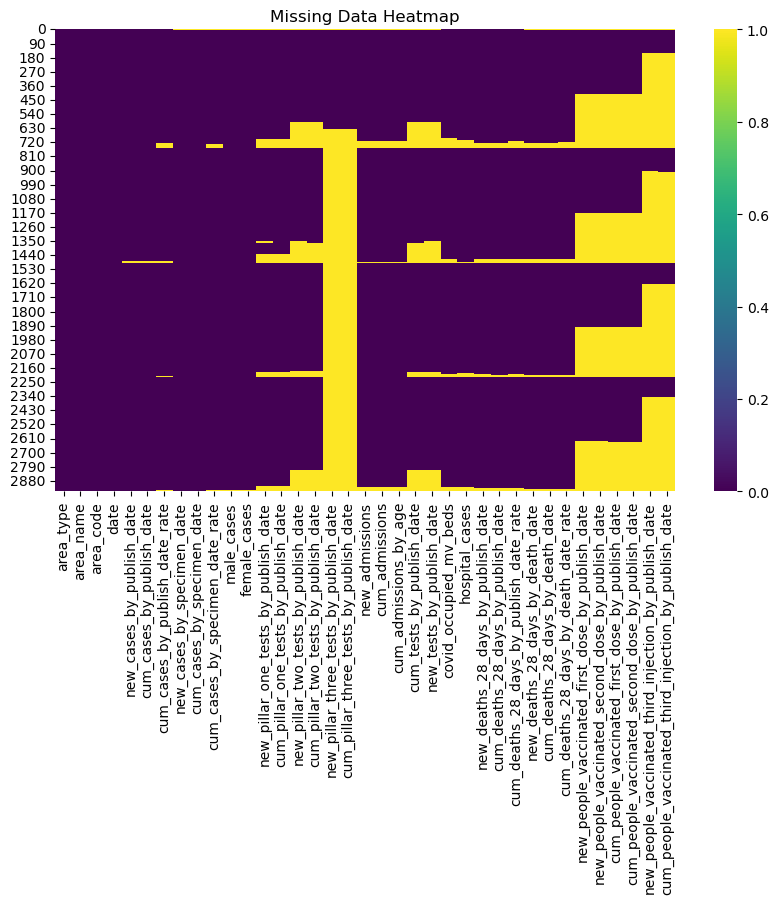

In [5]:
# Plot missing data heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [6]:
# Data cleaning
data.fillna(0, inplace=True)
data.drop_duplicates(inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [7]:
# Reverse the order of rows and compute daily changes
data = data[::-1].reset_index(drop=True)
data['daily_cases_change'] = data['cum_cases_by_publish_date'].diff().fillna(0)
data['daily_deaths_change'] = data['cum_deaths_28_days_by_publish_date'].diff().fillna(0)
data['daily_vaccinations_change'] = data['cum_people_vaccinated_first_dose_by_publish_date'].diff().fillna(0)
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['day_of_week'] = data['date'].dt.dayofweek

In [8]:

# Define year partition function
def determine_year_quarter(date):
    if date.year == 2020:
        return (date.month - 2) // 3
    elif date.year == 2021:
        return (date.month - 1) // 3 + 3
    elif date.year == 2022 and date.month <= 2:
        return 7
    return None


In [9]:
data['year_quarter'] = data['date'].apply(determine_year_quarter).astype('Int64')

In [10]:

# Parse cases data
def parse_json_data(cell_value):
    try:
        return ast.literal_eval(cell_value)
    except (ValueError, SyntaxError):
        return []

In [11]:
def extract_age_group_value(parsed_list, age_group):
    for item in parsed_list:
        if item['age'] == age_group:
            return item['value']
    return None

In [12]:
age_groups = ['0_to_4', '5_to_9', '10_to_14', '15_to_19', '20_to_24', '25_to_29', '30_to_34', 
               '35_to_39', '40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', 
               '65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90+']

In [13]:
data['parsed_male_cases'] = data['male_cases'].apply(parse_json_data)
data['parsed_female_cases'] = data['female_cases'].apply(parse_json_data)

In [14]:
for age_group in age_groups:
    data[f'male_cases_{age_group}'] = data['parsed_male_cases'].apply(lambda x: extract_age_group_value(x, age_group))
    data[f'female_cases_{age_group}'] = data['parsed_female_cases'].apply(lambda x: extract_age_group_value(x, age_group))

In [15]:
data.drop(columns=['parsed_male_cases', 'parsed_female_cases'], inplace=True)

In [16]:
# Define criteria for column selection
criteria = [
    'cum_cases_by', 'new_cases_by', 'cum_pillar_', 'new_pillar_', 'cum_deaths_28_days_by', 'new_people_vaccinated'
]

In [17]:
# Select columns based on criteria
selected_columns = [col for col in data.columns if any(criterion in col for criterion in criteria)]

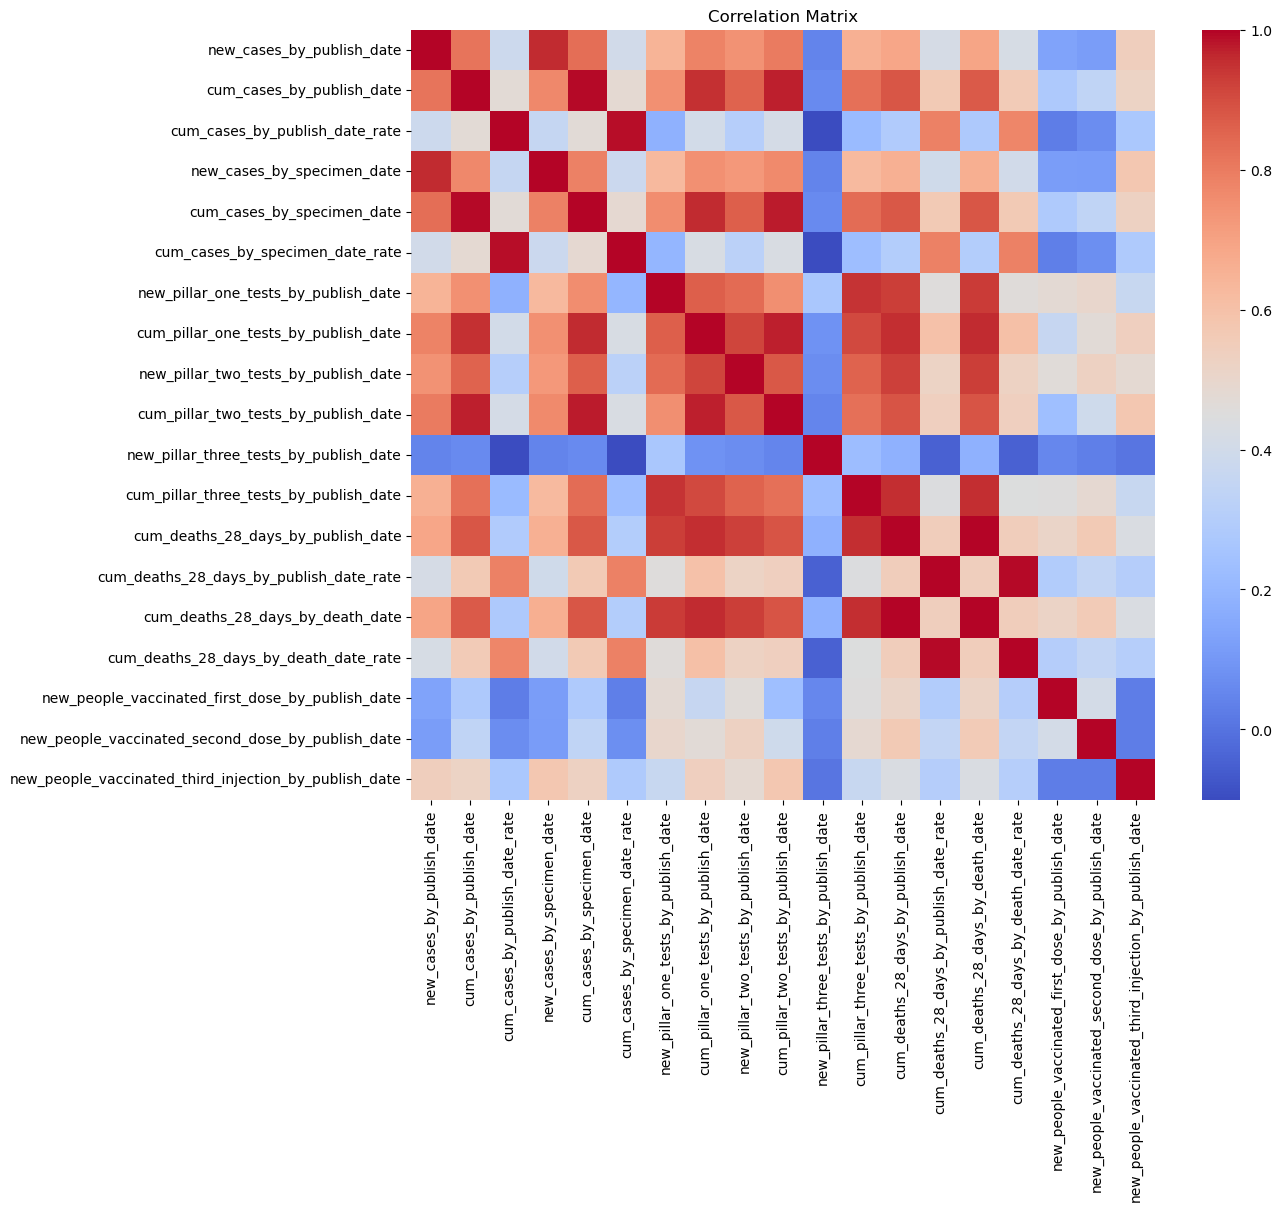

In [18]:
# Verify and apply column selection
if selected_columns:
    data[selected_columns] = data[selected_columns].apply(pd.to_numeric, errors='coerce')
    plt.figure(figsize=(12, 10))
    sns.heatmap(data[selected_columns].corr(), annot=False, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [19]:
# Save and reload cleaned data
cleaned_data_path = r'cleaned_nation_data_final.csv'
data.to_csv(cleaned_data_path, index=False)
data = pd.read_csv(cleaned_data_path)

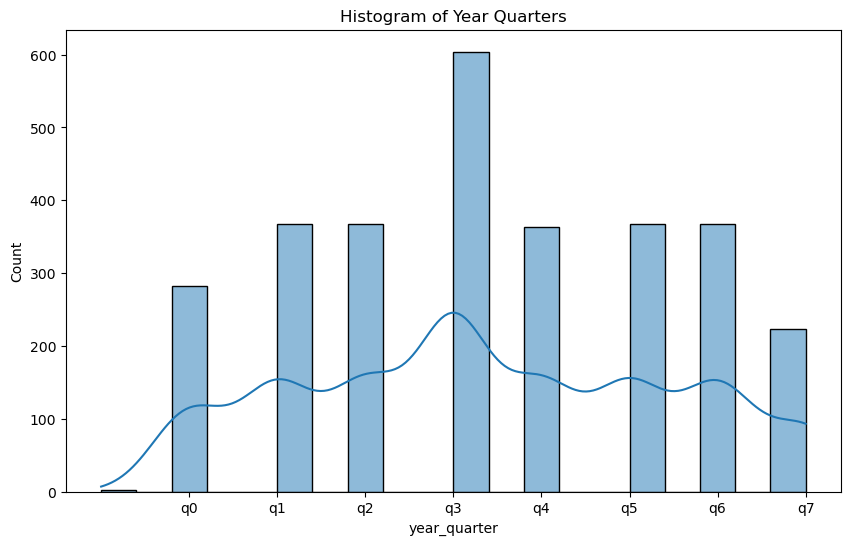

In [20]:

# Plot histogram and count of year quarters
plt.figure(figsize=(10, 6))
sns.histplot(data["year_quarter"], bins=20, kde=True)
plt.title('Histogram of Year Quarters')
plt.xticks(ticks=range(8), labels=['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

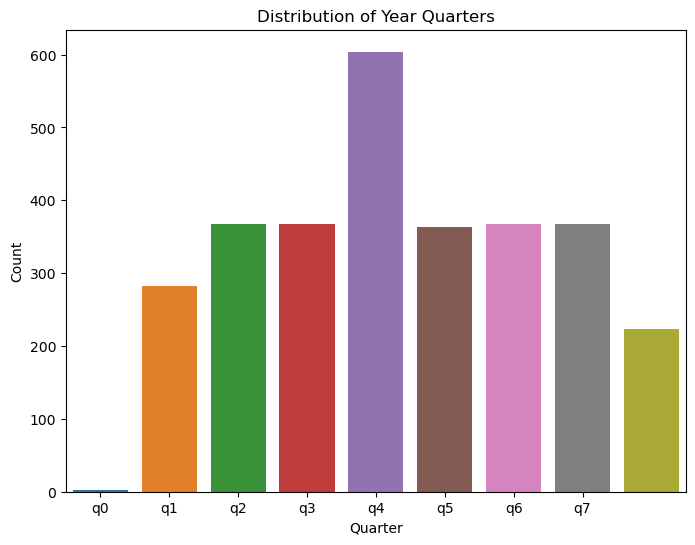

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x='year_quarter', data=data)
plt.title('Distribution of Year Quarters')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(ticks=range(8), labels=['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7'])
plt.show

In [22]:
# One-hot encode categorical columns and clean the data
data = pd.get_dummies(data, columns=['area_type', 'area_name', 'area_code'], drop_first=True)
data = data.drop(['male_cases', 'female_cases', 'cum_admissions_by_age'], axis=1)
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

In [23]:
# Prepare data for modeling
features = data.drop('cum_cases_by_publish_date', axis=1)
target = data['cum_cases_by_publish_date']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [24]:
# Train and evaluate models
model_dict = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}


In [27]:
# Initialize lists to store results
rmse_list = []
r2_list = []

Linear Regression:
  RMSE: 306669.71
  R^2 Score: 0.9828


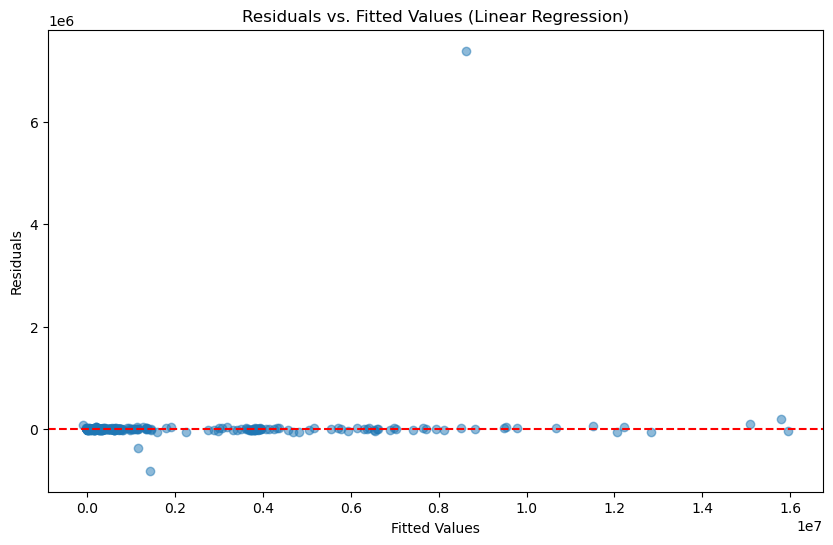

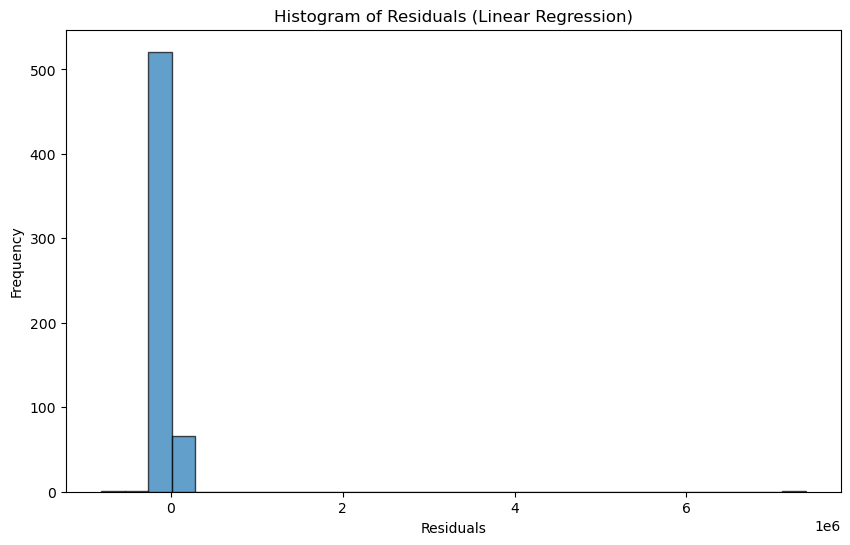

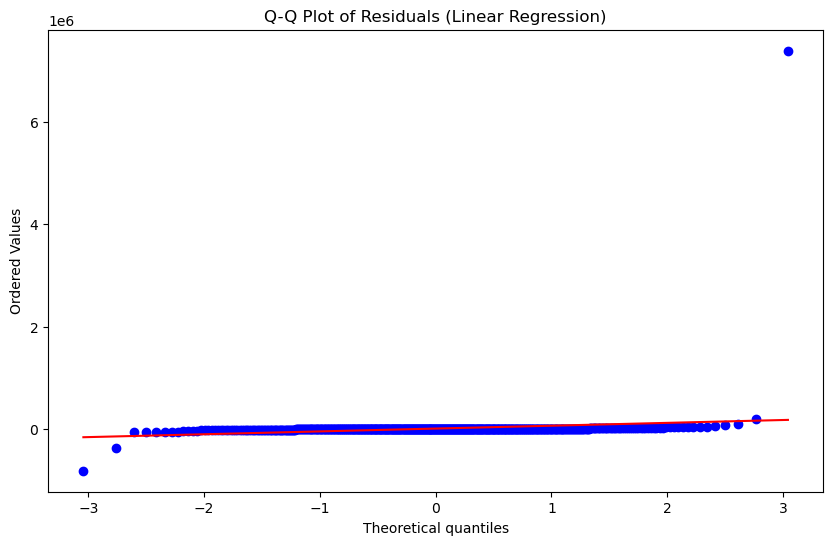

Lasso Regression:
  RMSE: 901246.68
  R^2 Score: 0.8514


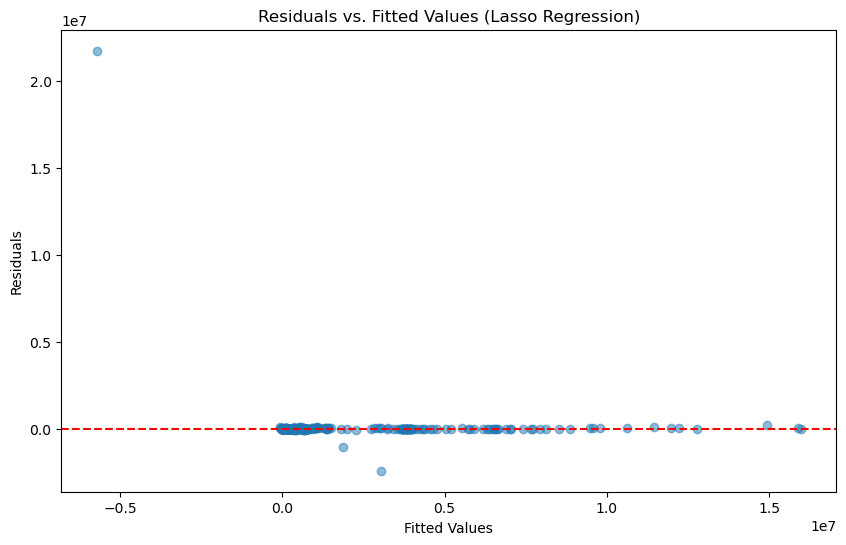

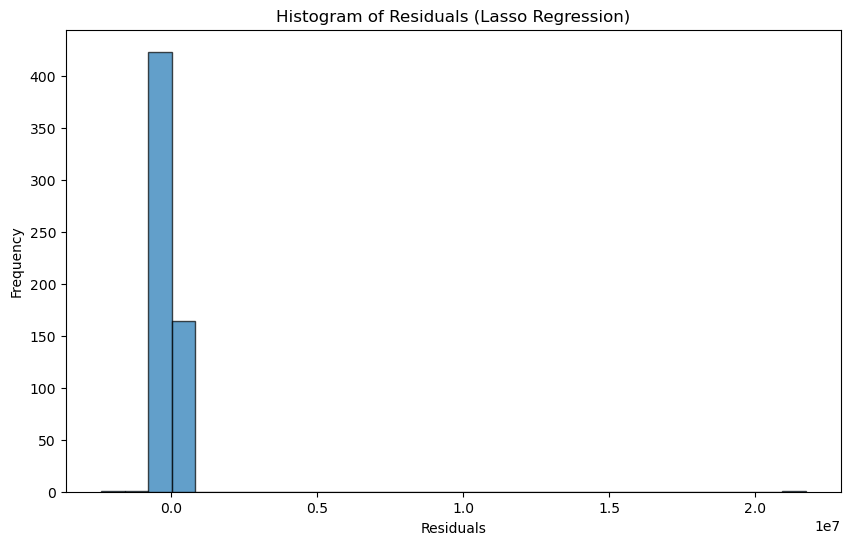

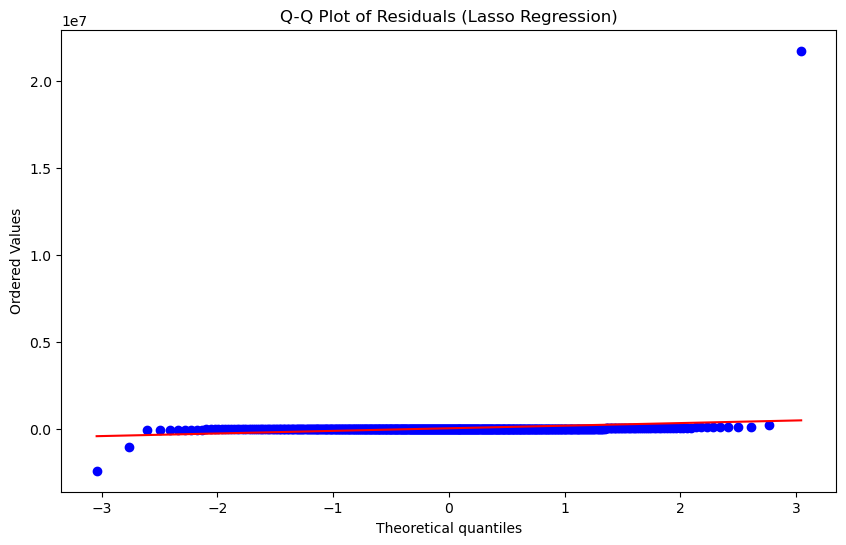

Decision Tree:
  RMSE: 603726.24
  R^2 Score: 0.9333


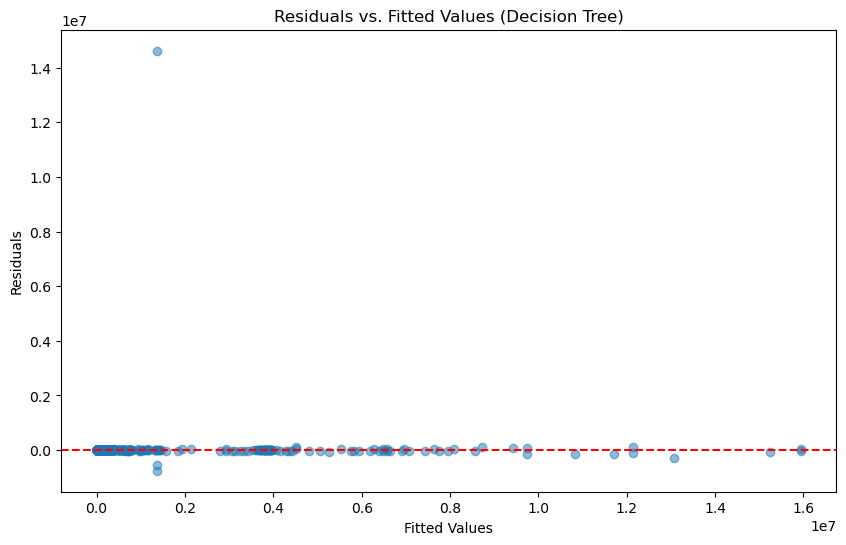

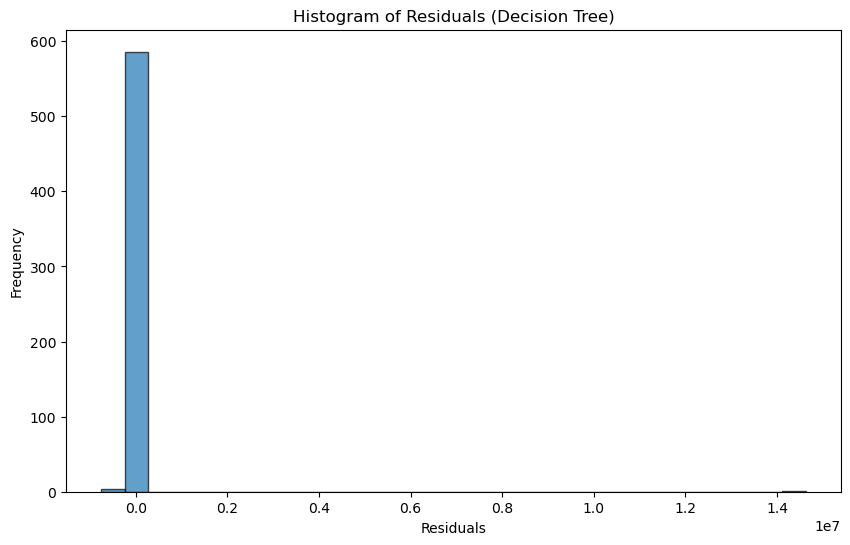

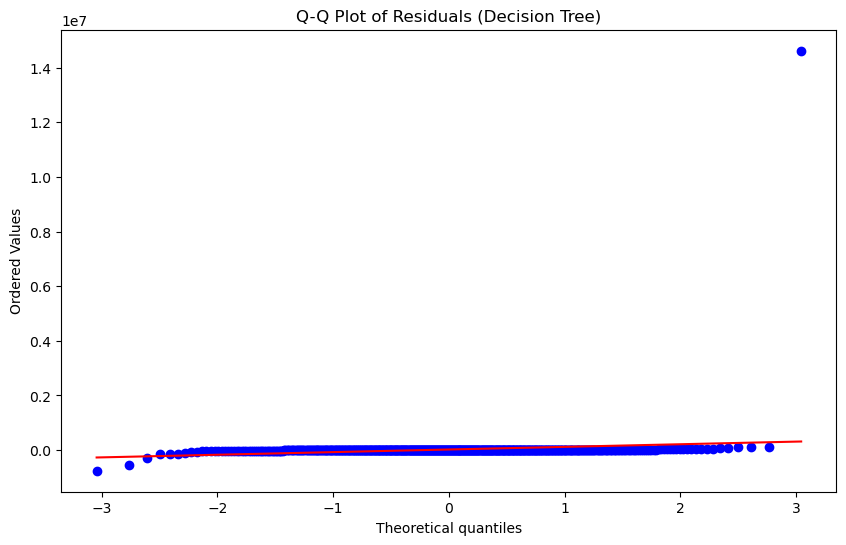

Random Forest:
  RMSE: 612312.74
  R^2 Score: 0.9314


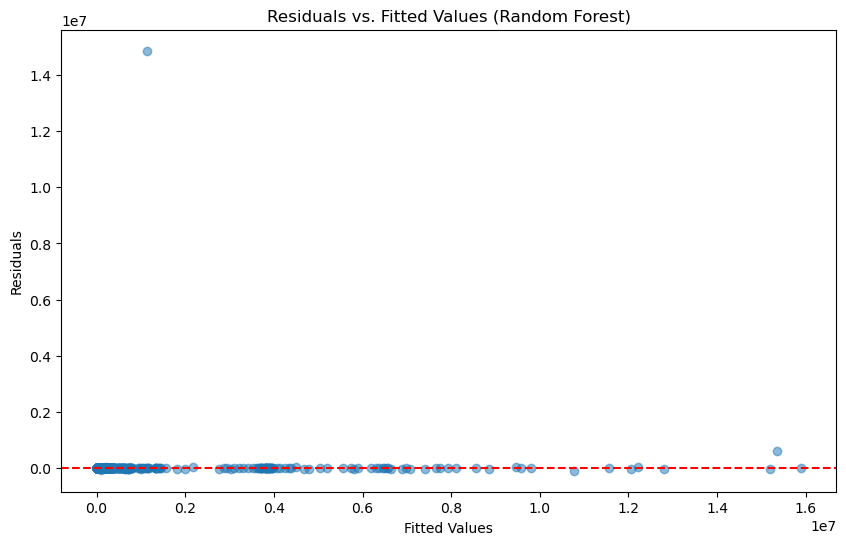

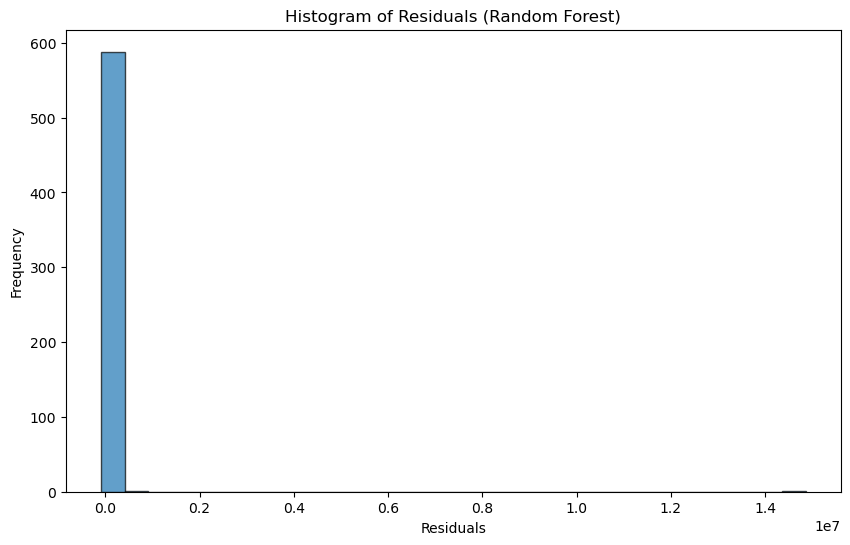

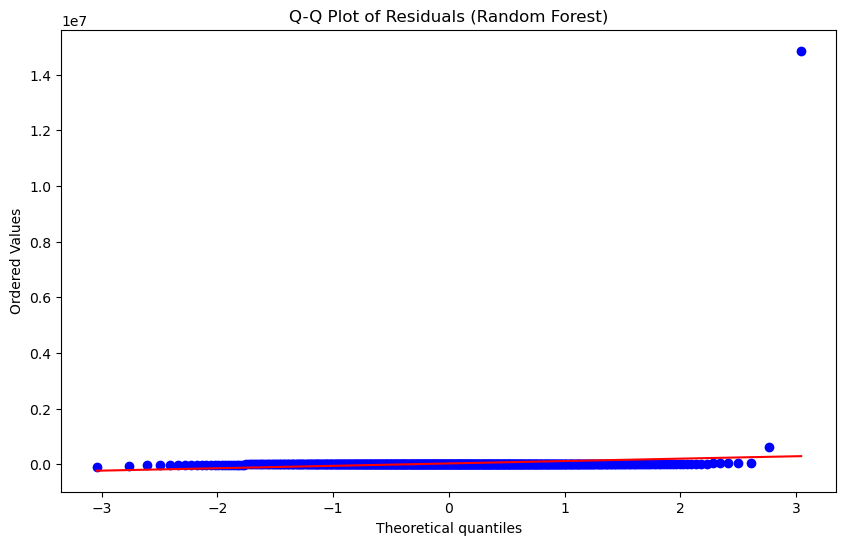

Gradient Boosting:
  RMSE: 586684.59
  R^2 Score: 0.9370


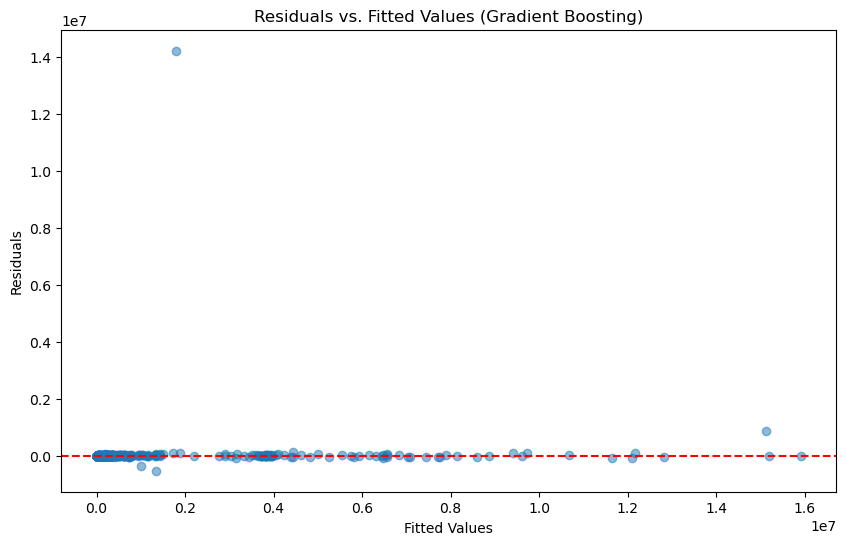

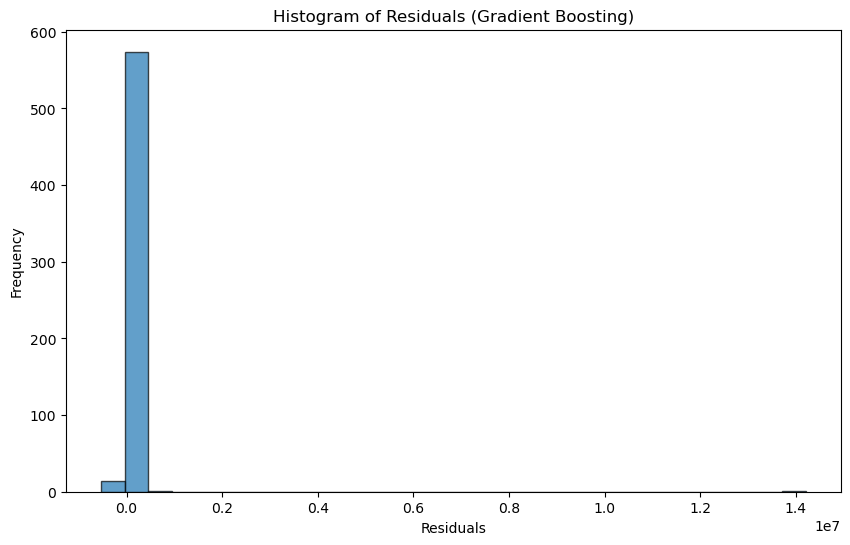

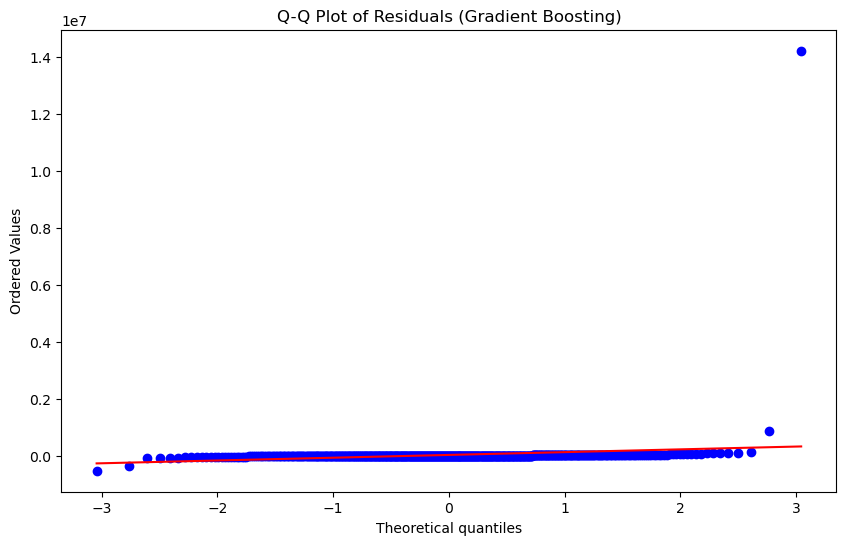

In [28]:
# Train and evaluate models
for model_name, model_instance in model_dict.items():
    model_instance.fit(X_train, y_train)
    predictions = model_instance.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    print(f'{model_name}:\n  RMSE: {rmse:.2f}\n  R^2 Score: {r2:.4f}')

    # Plot residuals
    residuals = y_test - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted Values ({model_name})')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals ({model_name})')
    plt.show()

    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of Residuals ({model_name})')
    plt.show()

Comparison of Regression Models:
               Model           RMSE  R^2 Score
0  Linear Regression  306669.707617   0.982794
1   Lasso Regression  901246.684663   0.851396
2      Decision Tree  603726.236358   0.933316
3      Random Forest  612312.742201   0.931406
4  Gradient Boosting  586684.586230   0.937027


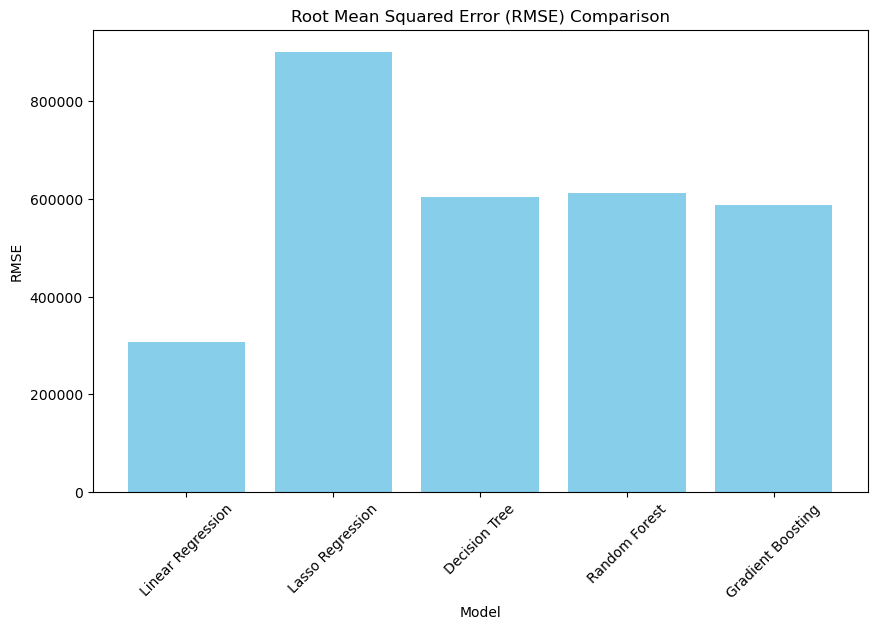

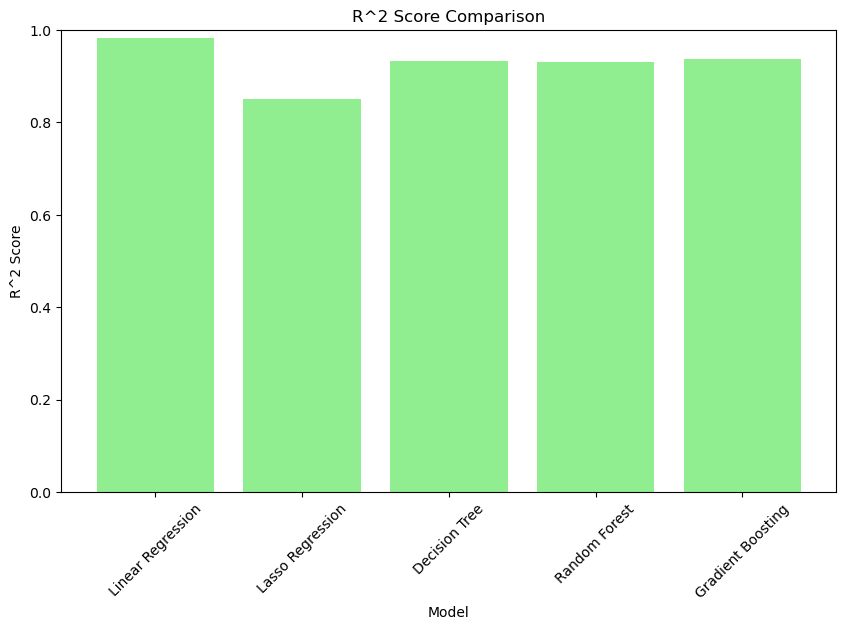

In [29]:
# Create a DataFrame to compare results
models_results = pd.DataFrame({
    'Model': list(model_dict.keys()),
    'RMSE': rmse_list,
    'R^2 Score': r2_list
})

# Print results in a readable format
print("Comparison of Regression Models:")
print(models_results)

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
plt.bar(models_results['Model'], models_results['RMSE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot R^2 Score comparison
plt.figure(figsize=(10, 6))
plt.bar(models_results['Model'], models_results['R^2 Score'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('R^2 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()